## Smoothing of transition matrices

In [1]:
import numpy as np
import pandas as pd

import catboost

import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sns.set_palette('deep')

## Parameters

In [2]:
## Benchmarks 

statespace: list[float] = np.linspace(0, 500, 101)
action_space: list[float] = [10, 20, 30, 40]
times: list[int] = np.arange(-50, 1)

BENCHMARKS = {
    'static-demand': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0,
        'time_effect': 0.0,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
   'time-varying-demand': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0,
        'time_effect': 0.05,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
   'peak-varying-demand': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0.075,
        'time_effect': 0.0,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
   'all-effects': {
        'num_periods': 50,
        'price_effect': 0.08,
        'peak_effect': 0.075,
        'time_effect': 0.05,
        'capacity': 500,
        'prices': [10, 20, 30, 40],
    },
}

### Dummy Data


In [3]:

class DummyData:
    """
    Generates dummy data for testing purposes.

    Produces a data frame of services where:
    - each service has a unique id
    - it departs at a given time of year
    - there is seasonal cycle to the demand for the service
    - demand for the service increases closer to departure date.
    """

    def __init__(
        self,
        num_periods: int = 100,
        price_effect: float = 0.08,
        peak_effect: float = 0.5,
        time_effect: float = 0.05,
        capacity: float = 500,
        prices: list[float] = [10, 20, 30, 40],
    ):
        self.T = num_periods
        assert self.T > 0, "Number of periods must be greater than 0."

        self.price_effect = price_effect
        self.peak_effect = peak_effect
        self.time_effect = time_effect
        self.prices = prices
        self.capacity = capacity

        self.noise_std = 0.1

        return None

    def demand_curve(
        self,
        price: np.ndarray,
        t: np.ndarray,
        peak: np.ndarray,
    ) -> np.ndarray:
        """
        Generate demand for a service.
        """

        Q = (
            50
            * (np.exp(-self.price_effect * price) + self.peak_effect * peak)
            * np.exp(-self.time_effect * np.abs(t))
        )

        return Q

    def generate(self):
        """
        Generate dummy data.
        """

        # We'll have a service departing every day between 2000-01-01 and
        # 2005-01-01
        departure_date = pd.date_range(
            start="2000-01-01", end="2005-01-01", freq="D"
        )

        selling_window = -np.arange(0, self.T)

        # Cross join departure_date and selling_window
        df = pd.DataFrame(departure_date, columns=["departure_date"])
        df["key"] = 1
        selling_window = pd.DataFrame(selling_window, columns=["t"])
        selling_window["key"] = 1
        df = df.merge(selling_window, on="key")
        df.drop(columns=["key"], inplace=True)

        # Generate a 'peak' variable. This is 1 if we're in Q1 or Q3.
        df["peak"] = (df["departure_date"].dt.quarter == 1) | (
            df["departure_date"].dt.quarter == 3
        )
        df["peak"] = df["peak"].astype(int)

        # --------------------------------------------------------------------#
        # Pick price as a random flip of a coin
        df["a"] = np.random.choice(self.prices, df.shape[0])

        # We want the price to be randomly chosen, but in sequences of 20 periods.
        # This is to simulate the fact that prices don't change every day.

        # How many sequences of length 20 can we fit in the data?
        n_sequences = df.shape[0] // 20

        # Produce this many sequences of 20 periods
        for i in range(n_sequences):
            df.loc[i * 20 : (i + 1) * 20, "a"] = np.random.choice(
                self.prices, 1
            )[0]

        # --------------------------------------------------------------------#

        # Generate q (demand)
        df["q"] = self.demand_curve(
            price=df["a"],
            t=df["t"],
            peak=df["peak"],
        ) + np.random.normal(0, self.noise_std, df.shape[0])

        # Make sure q is non-negative
        df["q"] = np.maximum(df["q"], 0)

        # Construct q_cumulative_prime within the date ordered by selling window
        df = df.sort_values(by=["departure_date", "t"], ascending=[True, True])
        df["q_cumulative_prime"] = df.groupby("departure_date")["q"].cumsum()

        # Make sure q_cumulative_prime doesn't exceed capacity
        df["q_cumulative_prime"] = np.minimum(
            df["q_cumulative_prime"], self.capacity
        )

        # Construct q_cumulative
        df["q_cumulative"] = df.groupby("departure_date")[
            "q_cumulative_prime"
        ].shift(1)

        # Construct s_prime
        df["s_prime"] = self.capacity - df["q_cumulative_prime"]

        # Construct s
        df["s"] = (
            df.groupby("departure_date")["s_prime"]
            .shift(1)
            .fillna(self.capacity)
        )

        # Construct `relative_departure_date` variable
        df["departure_date_unix"] = (
            df["departure_date"].astype("int64") // 10**9
        )

        # Construct `departure_year` variable
        df["departure_year"] = df["departure_date"].dt.year

        # Construct `departure_month` variable
        df["departure_month"] = df["departure_date"].dt.month

        # Construct `departure_day_of_year` variable
        df["departure_day_of_year"] = df["departure_date"].dt.dayofyear

        # Construct `service_id` column (just departure date for now)
        df["departure_date"] = pd.to_datetime(df["departure_date"]).dt.date
        df["service_id"] = df["departure_date"]

        df["capacity"] = self.capacity

        # Columns should be in order of service_id, q, a, t, s, s_prime, and
        # the rest.
        first_cols = [
            "service_id",
            "q",
            "a",
            "t",
            "s",
            "s_prime",
        ]
        rest_cols = list(df.columns.difference(first_cols))

        # Reorder columns
        df = df[first_cols + rest_cols]

        # set nan to 0
        df.fillna(0, inplace=True)

        # drop index
        df.reset_index(drop=True, inplace=True)

        return df


In [4]:
# Utility functions


def discritize_space(
    df: pd.DataFrame, column: str, statespace: list
) -> pd.DataFrame:
    """
    Discretize the column into a specified number of bins and sets value as the midpoint.

    Args:
        df : Input DataFrame.
        column : Column to be discritized.
        statespace : List of bins.

    Returns:
        pd.DataFrame : DataFrame with column discritized.
    """
    logger.info(f"Discretizing column {column} into {len(statespace)} bins...")

    df[f"{column}_disc"] = pd.cut(
        df[column], bins=len(statespace), labels=statespace
    ).astype(str)
    logger.info("Column discretized")
    return df



In [5]:
dummy_data = DummyData(**BENCHMARKS['static-demand'])

df = dummy_data.generate()

In [6]:
df.head()

,service_id,q,a,t,s,s_prime,capacity,departure_date,departure_date_unix,departure_day_of_year,departure_month,departure_year,peak,q_cumulative,q_cumulative_prime
0,2000-01-01,2.104276,40,-49,500.000000,497.895724,500,2000-01-01,946684800,1,1,2000,1,0.000000,2.104276
1,2000-01-01,2.377565,40,-48,497.895724,495.518160,500,2000-01-01,946684800,1,1,2000,1,2.104276,4.481840
2,2000-01-01,2.094566,40,-47,495.518160,493.423594,500,2000-01-01,946684800,1,1,2000,1,4.481840,6.576406
3,2000-01-01,2.141560,40,-46,493.423594,491.282034,500,2000-01-01,946684800,1,1,2000,1,6.576406,8.717966
4,2000-01-01,2.037271,40,-45,491.282034,489.244764,500,2000-01-01,946684800,1,1,2000,1,8.717966,10.755236


In [7]:
# Discretize the state space
df = discritize_space(df, "s", statespace)
df = discritize_space(df, "s_prime", statespace)


# Make categorical variables with statespace as values
df["s_disc"] = pd.Categorical(df["s_disc"].astype(float), categories=statespace, ordered=True)
df["s_prime_disc"] = pd.Categorical(df["s_prime_disc"].astype(float), categories=statespace, ordered=True)

df.head()

INFO:__main__:Discretizing column s into 101 bins...
INFO:__main__:Column discretized
INFO:__main__:Discretizing column s_prime into 101 bins...
INFO:__main__:Column discretized


,service_id,q,a,t,s,s_prime,capacity,departure_date,departure_date_unix,departure_day_of_year,departure_month,departure_year,peak,q_cumulative,q_cumulative_prime,s_disc,s_prime_disc
0,2000-01-01,2.104276,40,-49,500.000000,497.895724,500,2000-01-01,946684800,1,1,2000,1,0.000000,2.104276,500.0,500.0
1,2000-01-01,2.377565,40,-48,497.895724,495.518160,500,2000-01-01,946684800,1,1,2000,1,2.104276,4.481840,500.0,500.0
2,2000-01-01,2.094566,40,-47,495.518160,493.423594,500,2000-01-01,946684800,1,1,2000,1,4.481840,6.576406,500.0,500.0
3,2000-01-01,2.141560,40,-46,493.423594,491.282034,500,2000-01-01,946684800,1,1,2000,1,6.576406,8.717966,495.0,495.0
4,2000-01-01,2.037271,40,-45,491.282034,489.244764,500,2000-01-01,946684800,1,1,2000,1,8.717966,10.755236,495.0,495.0


In [8]:
# Pick a random subset of data

ix = df.sample(int(.8*len(df))).index
train_df = df.loc[ix].copy()
train_df.reset_index(drop=True, inplace=True)

val_df = df.drop(ix).copy()
val_df.reset_index(drop=True, inplace=True)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


Train set size: 73120
Validation set size: 18280


In [9]:
PARAMS = {
    "iterations": 100,
    "eval_metric": "TotalF1",
      "early_stopping_rounds": 20,
      "verbose": 50,
      "random_seed": 42,
      "loss_function": "MultiClass",
      "auto_class_weights": "Balanced",
      "subsample": 0.8,
      "bootstrap_type": "Bernoulli",
      "use_best_model": True
    }


model = catboost.CatBoostClassifier(**PARAMS)

In [10]:
X_cols = [
    's',
    'a',
    't',
]
y_col = [
    's_prime_disc',
]

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_val = val_df[X_cols]
y_val = val_df[y_col]

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
)



Learning rate set to 0.283536
0:	learn: 0.0319004	test: 0.0298468	best: 0.0298468 (0)	total: 303ms	remaining: 30s
50:	learn: 0.8288438	test: 0.8235875	best: 0.8235875 (50)	total: 11.7s	remaining: 11.2s
99:	learn: 0.9046160	test: 0.8986379	best: 0.8986379 (99)	total: 23s	remaining: 0us

bestTest = 0.8986379494
bestIteration = 99



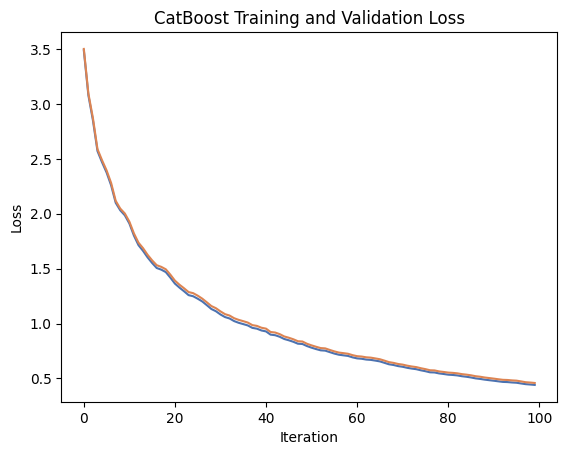

In [11]:
evals_result = model.get_evals_result()
train_loss = evals_result.get("learn", {}).get("MultiClass", [])
val_loss = evals_result.get("validation", {}).get("MultiClass", [])

sns.lineplot(
    x=np.arange(len(train_loss)),
    y=train_loss,
)
sns.lineplot(
    x=np.arange(len(val_loss)),
    y=val_loss,
)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("CatBoost Training and Validation Loss")

plt.show()

In [12]:
# Pick a action and time.

a = 10
t = -20

pred_df = pd.DataFrame({
    "s": statespace,
    "a": a,
    "t": t,
})


transition_matrix = model.predict_proba(pred_df)
transition_matrix = pd.DataFrame(
    transition_matrix, columns=model.classes_, index=statespace
)


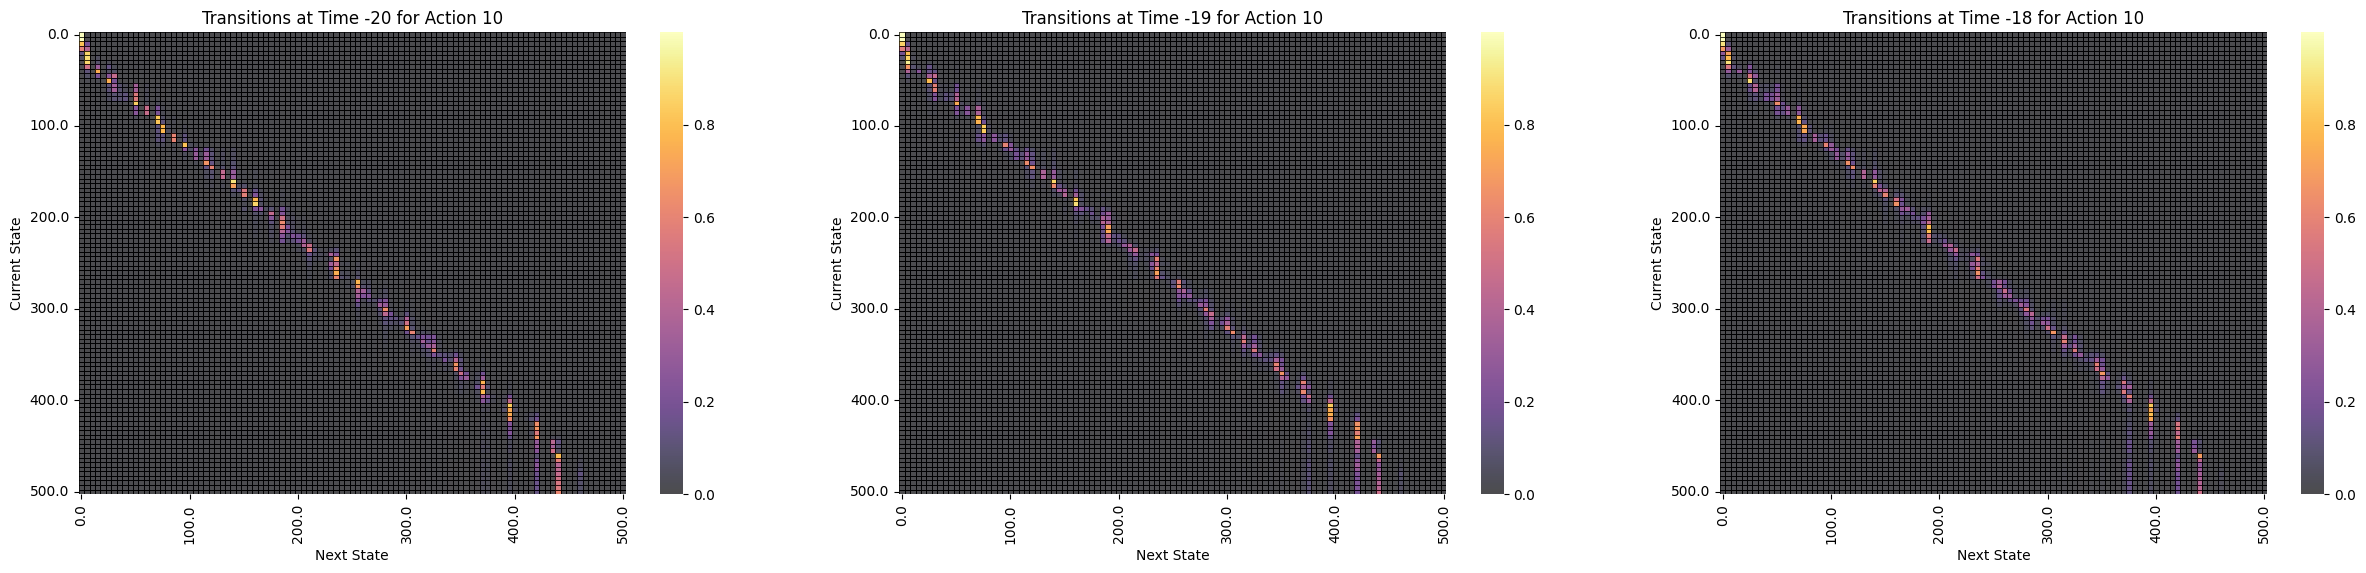

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6))

annotate = False

a = 10

transitions = []

for i, t in enumerate([-20,-19, -18]):
    
    pred_df = pd.DataFrame({
    "s": statespace,
    "a": a,
    "t": t,
    })


    transition_matrix = model.predict_proba(pred_df)
    transition_matrix = pd.DataFrame(
        transition_matrix, columns=model.classes_, index=statespace
    )

    transitions.append(transition_matrix)

    sns.heatmap(
        transition_matrix,
        xticklabels=statespace,
        yticklabels=statespace,
        ax=ax[i],
        annot=annotate,
        linewidths=0.5,
        linecolor="black",
        cmap="inferno",
        alpha=0.7,
    )
    ax[i].set_xlabel("Next State")
    ax[i].set_ylabel("Current State")
    ax[i].set_title(f"Transitions at Time {t} for Action {a}")

    # Reduce the number of labels to at most 5
    max_labels = 5
    if max_labels is not None:
        x_labels = ax[i].get_xticks()
        y_labels = ax[i].get_yticks()
        ax[i].set_xticks(x_labels[:: max(1, len(x_labels) // max_labels)])
        ax[i].set_yticks(y_labels[:: max(1, len(y_labels) // max_labels)])



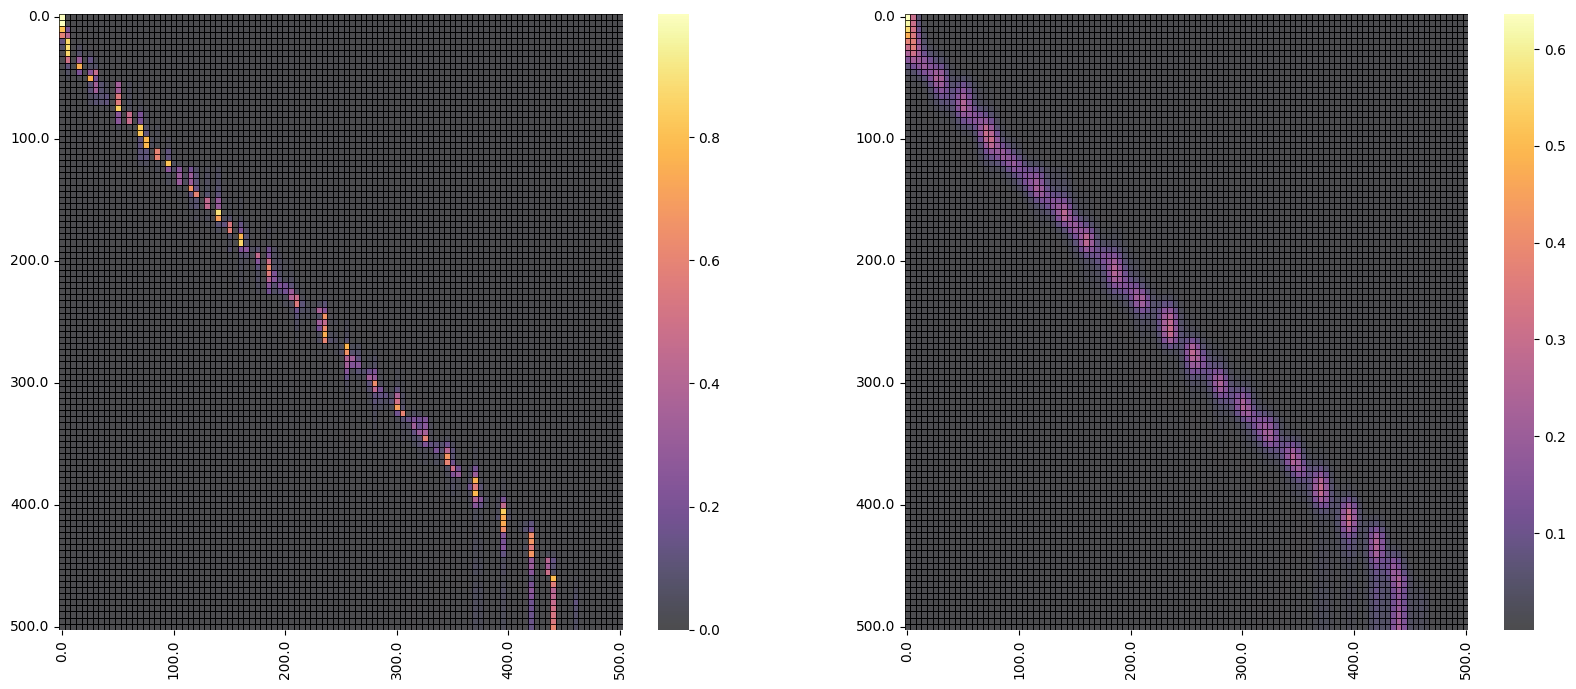

In [100]:
# transitions contains 3 matrices. Average these and plot the average transition matrix.

from scipy.ndimage import gaussian_filter
from sklearn import preprocessing
from scipy.sparse import csr_matrix

T = transitions[0].copy()

# Make T a sparse csr matrx
T = csr_matrix(T.values)
T = T.todense()




# Smooth the diagonals of T


#T_smoothed = smooth_diagonals(T.to_numpy(), filter_size=3, sigma=1)
#T_smoothed = gaussian_filter(T_smoothed, sigma=.5)

# Now gaussian smooth over columns

T_smoothed = gaussian_filter(T, sigma=(1, 1))



T_smoothed = preprocessing.normalize(T_smoothed, norm="l1", axis=1)


##########################################
# Plot

fig, ax = plt.subplots(1, 2, figsize=(20, 8))


sns.heatmap(
    T,
    xticklabels=statespace,
    yticklabels=statespace,
    annot=annotate,
    linewidths=0.5,
    linecolor="black",
    cmap="inferno",
    alpha=0.7,
    ax=ax[0],
)

max_labels = 5
if max_labels is not None:
    x_labels = ax[0].get_xticks()
    y_labels = ax[0].get_yticks()
    ax[0].set_xticks(x_labels[:: max(1, len(x_labels) // max_labels)])
    ax[0].set_yticks(y_labels[:: max(1, len(y_labels) // max_labels)])




sns.heatmap(
    T_smoothed,
    xticklabels=statespace,
    yticklabels=statespace,
    annot=annotate,
    linewidths=0.5,
    linecolor="black",
    cmap="inferno",
    alpha=0.7,
    ax=ax[1],
)

max_labels = 5
if max_labels is not None:
    x_labels = ax[1].get_xticks()
    y_labels = ax[1].get_yticks()
    ax[1].set_xticks(x_labels[:: max(1, len(x_labels) // max_labels)])
    ax[1].set_yticks(y_labels[:: max(1, len(y_labels) // max_labels)])




In [59]:
import numpy as np
from scipy.ndimage import uniform_filter1d, gaussian_filter

def smooth_diagonals(matrix, filter_size=3, sigma=1.0):
    smoothed_matrix = np.copy(matrix)
    n, m = matrix.shape
    
    # Loop over all diagonals (from -(n-1) to m-1)
    for k in range(-(n-1), m):
        diag = matrix.diagonal(offset=k)
        
        # Apply smoothing filter (uniform moving average here)
        #smoothed_diag = uniform_filter1d(diag, size=filter_size, mode='nearest')
        smoothed_diag = gaussian_filter(diag, sigma=sigma)
        
        # Put smoothed diagonal back
        # Extract indices of diagonal elements
        if k >= 0:
            rows = np.arange(min(n, m - k))
            cols = rows + k
        else:
            cols = np.arange(min(m, n + k))
            rows = cols - k
        
        smoothed_matrix[rows, cols] = smoothed_diag
    
    return smoothed_matrix

